In [152]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

!pip show equinox || echo equinox not found. Installing... && pip install equinox 2> /dev/null

Name: equinox
Version: 0.11.2
Summary: Elegant easy-to-use neural networks in JAX.
Home-page: 
Author: 
Author-email: Patrick Kidger <contact@kidger.site>
License: Apache License
                           Version 2.0, January 2004
                        http://www.apache.org/licenses/

   TERMS AND CONDITIONS FOR USE, REPRODUCTION, AND DISTRIBUTION

   1. Definitions.

      "License" shall mean the terms and conditions for use, reproduction,
      and distribution as defined by Sections 1 through 9 of this document.

      "Licensor" shall mean the copyright owner or entity authorized by
      the copyright owner that is granting the License.

      "Legal Entity" shall mean the union of the acting entity and all
      other entities that control, are controlled by, or are under common
      control with that entity. For the purposes of this definition,
      "control" means (i) the power, direct or indirect, to cause the
      direction or management of such entity, whether by cont

# Spectral Bias of Neural Networks

It has been observed, see [Rahaman et al. 2019](https://arxiv.org/abs/1806.08734), that neural networks are biased towards the low frequency components of the input signal. This bias is known as the spectral bias of neural networks.
This problem inhibits the ability to train PINNs for high frequency problems, e.g., problems exhibiting localized features like shocks, boundary layers, etc.
The problem of spectral bias can be understood theoretically using the neural tangent kernel (NTK) framework.
We will demonstrate this bias using a simple example.
We will train a simple MLP to approximate a function with a low frequency and a high frequency component.
We will check how the MLP does after each epoch.
You should notice that the MLP is biased towards the low frequency component of the function.
Only after a large number of epochs, the MLP starts to capture the high frequency component of the function.

## Numerical Example

The function we will use is given by

$$
f(x) = \sin(2\pi x) + 0.5\sin(16\pi x),
$$

for $x \in [0, 1]$.

Let's visualize it and the data we will use for training the neural network.

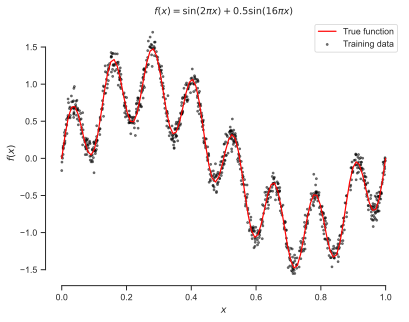

In [2]:
import numpy as np
import jax.numpy as jnp

f = lambda x: jnp.sin(2.0 * jnp.pi * x) + 0.5 * jnp.sin(16.0 * jnp.pi * x)

num_train = 1_000
x_train = np.random.rand(num_train)
y_train = f(x_train) + np.random.randn(num_train) * 0.1

fig, ax = plt.subplots()
x = jnp.linspace(0, 1, 100)
ax.plot(x, f(x), 'r-', label='True function')
ax.scatter(x_train, y_train, s=4, c='black', alpha=0.5, label='Training data')
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$f(x)$")
ax.set_title(r"$f(x) = \sin(2\pi x) + 0.5 \sin(16\pi x)$")
ax.legend(loc='best', frameon=True)
sns.despine(trim=True);

The following code trains a generic neural on the data.
It returns the trained model after each epoch.

In [3]:
import equinox as eqx
import optax

    
def data_generator(X, y, batch_size, shuffle=True):
    num_samples = X.shape[0]
    indices = np.arange(num_samples)
    if shuffle:
        np.random.shuffle(indices)
    
    for start_idx in range(0, num_samples, batch_size):
        end_idx = min(start_idx + batch_size, num_samples)
        batch_indices = indices[start_idx:end_idx]
        yield X[batch_indices], y[batch_indices]

def loss(model, x, y):
    y_pred = model(x).flatten()
    return optax.l2_loss(y_pred, y).mean()

def train_batch(
        model,
        x, y,
        optimizer,
        n_batch=10,
        n_epochs=10,
        freq=1_000,
    ):

    # This is the step of the optimizer. We **always** jit:
    @eqx.filter_jit
    def step(opt_state, model, xi, yi):
        value, grads = eqx.filter_value_and_grad(loss)(model, xi, yi)
        updates, opt_state = optimizer.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, value
    
    # The state of the optimizer
    opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))
    # The path of the model
    path = []
    # The path of the test loss
    losses = []
    for e in range(n_epochs):
        for i, (xb, yb) in enumerate(data_generator(x, y, n_batch)):
            model, opt_state, value = step(opt_state, model, xb[:, None], yb)
            if i % freq == 0:
                path.append(model)
                losses.append(value)
                print(f"Epoch {e}, step {i}, loss {value:.3f}, test {losses[-1]:.3f}")
    return model, path, losses

Let's also write some code to visualize the predictions of the model after each epoch.

In [4]:
def plot(model, x_train, y_train, f_true, style='b--'):
    x = jnp.linspace(0, 1, 100)[:, None]
    fig, ax = plt.subplots()
    ax.plot(x, f_true(x), 'r-', label='True function')
    ax.scatter(x_train, y_train, s=4, c='black', alpha=0.5, label='Training data')
    ax.plot(x, model(x), style, label='Model')
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$f(x)$")
    ax.set_title(r"$f(x) = \sin(2\pi x) + 0.5 \sin(16\pi x)$")
    ax.legend(loc='best')
    sns.despine(trim=True);
    return fig, ax

We will try this on a simple MLP:

In [5]:
import jax.random as jrandom

key = jrandom.PRNGKey(0)
subkey, key = jrandom.split(key)

width_size = 128
depth = 4
mlp = eqx.filter_vmap(
    eqx.nn.MLP(1, 1, width_size, depth, jnp.tanh, key=subkey))

optimizer = optax.adam(1e-3)
model, path, losses = train_batch(
    mlp, x_train, y_train, optimizer,
    n_batch=32, 
    n_epochs=300,
    freq=1_000
)

Epoch 0, step 0, loss 0.267, test 0.267
Epoch 1, step 0, loss 0.142, test 0.142
Epoch 2, step 0, loss 0.111, test 0.111
Epoch 3, step 0, loss 0.085, test 0.085
Epoch 4, step 0, loss 0.065, test 0.065
Epoch 5, step 0, loss 0.071, test 0.071
Epoch 6, step 0, loss 0.067, test 0.067
Epoch 7, step 0, loss 0.045, test 0.045
Epoch 8, step 0, loss 0.070, test 0.070
Epoch 9, step 0, loss 0.066, test 0.066
Epoch 10, step 0, loss 0.077, test 0.077
Epoch 11, step 0, loss 0.055, test 0.055
Epoch 12, step 0, loss 0.044, test 0.044
Epoch 13, step 0, loss 0.085, test 0.085
Epoch 14, step 0, loss 0.090, test 0.090
Epoch 15, step 0, loss 0.088, test 0.088
Epoch 16, step 0, loss 0.066, test 0.066
Epoch 17, step 0, loss 0.062, test 0.062
Epoch 18, step 0, loss 0.085, test 0.085
Epoch 19, step 0, loss 0.071, test 0.071
Epoch 20, step 0, loss 0.062, test 0.062
Epoch 21, step 0, loss 0.067, test 0.067
Epoch 22, step 0, loss 0.058, test 0.058
Epoch 23, step 0, loss 0.045, test 0.045
Epoch 24, step 0, loss 0.0

Now, let's plot the result after some of the epochs:

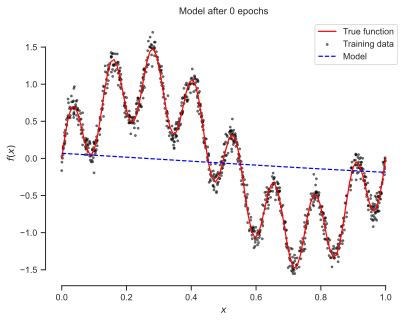

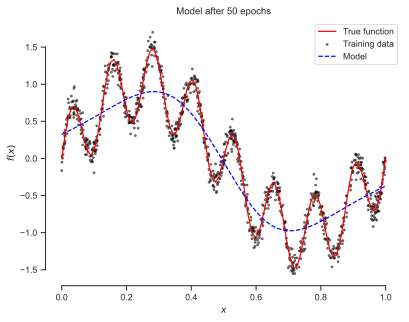

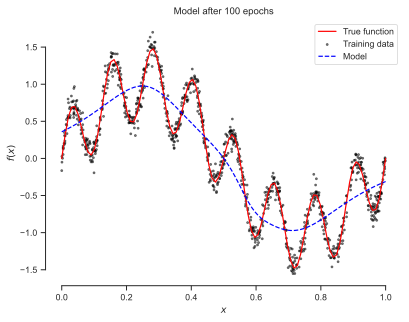

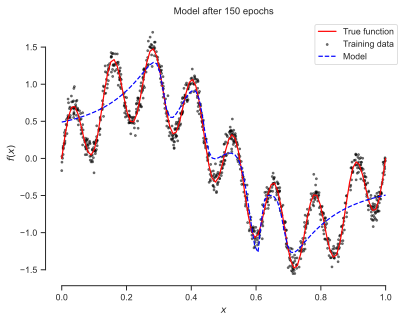

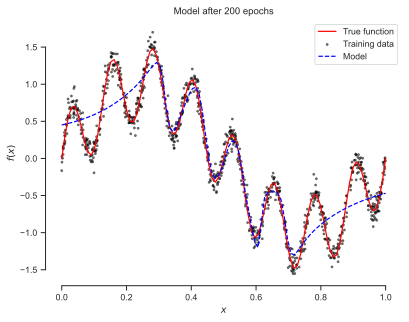

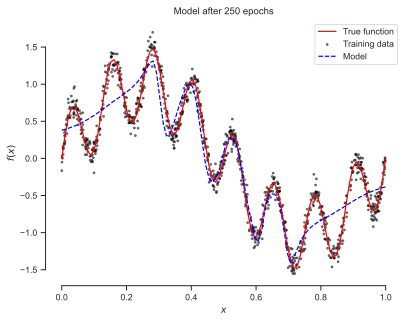

In [6]:
for e, model in enumerate(path[::50]):
    fig, ax = plot(model, x_train, y_train, f)
    ax.set_title(f"Model after {e * 50} epochs")

And you clearly observe the spectral bias problem.

## Random Fourier Features

One way to mitigate the spectral bias problem is to use random Fourier features, see [Tancik et al. 2020](https://arxiv.org/abs/2006.10739).
The idea is to map the input data to a higher dimensional space using random Fourier features.
The random Fourier features are designed to capture the high frequency components of the input signal.
These features go right before the input layer of the neural network.
Say our input data is $\mathbf{x} \in \mathbb{R}^d$ and that we want to map to a network with $m$-dimensional inputs.
Then, the random Fourier features are given by

$$
\boldsymbol{\phi}(\mathbf{x}) = 
\begin{bmatrix}
\cos(\mathbf{B}\mathbf{x}) \\
\sin(\mathbf{B}\mathbf{x})
\end{bmatrix},
$$

where $\mathbf{B}$ is a $m \times d$ matrix.
This matrix is constant throughout the training process.
But we typically pick it randomly from a Gaussian distribution.
Specifically, we pick each entry of $\mathbf{B}$ from a Gaussian distribution with mean 0 and variance $\sigma^2$.
Wang et al. suggest picking $\sigma$ in $[1,10]$ for PINNs applications.
The cosine and sine functions are applied element-wise.

## Applying Random Fourier Features to the Example

Let's implement random Fourier features and apply it to the previous example.

In [7]:
import jax
from functools import partial
import jax.tree_util as jtu


class FourierMLP(eqx.Module):
    mlp: eqx.nn.MLP
    B: jax.Array            # Remember that this needs to be fixed

    def __init__(self, in_size, fourier_features, width_size, depth, key, sigma=5.0):
        key1, key2 = jax.random.split(key, 2)
        self.mlp = eqx.nn.MLP(fourier_features * 2, 1, width_size, depth, jnp.tanh, key=key1)
        self.B = jax.random.normal(key2, (fourier_features, in_size)) * sigma
    
    @partial(eqx.filter_vmap, in_axes=(None, 0))
    def __call__(self, x):
        return self.eval(x)
    
    # Notice that I have to define the evaluation function
    # to separate the vmap from the evaluation
    # I will just need the evaluation for PINNs
    def eval(self, x):
        tmp = jnp.vstack([jnp.cos(self.B @ x[:, None]), jnp.sin(self.B @ x[:, None])]).flatten()
        return self.mlp(tmp)[0]

    # This is used for optimization - to freeze the Fourier features
    def make_filter_spec(self):
        filter_spec = jtu.tree_map(lambda _: True, self)
        filter_spec = eqx.tree_at(
            lambda tree: (tree.B,),
            filter_spec,
            replace=(False,),
        )
        return filter_spec

And here is how we can make the network.

In [8]:
num_fourier_features = 100
width_size = 128
depth = 4
sigma = 5.0

key, subkey = jax.random.split(key)
fourier_mlp = FourierMLP(1, num_fourier_features, width_size, depth, subkey)

Recall that we want to keep $\mathbf{B}$ constant throughout the training process.
We will have to modify our training algorithm to achieve this.
We will use `equinox.partition` capabilities to achieve this.

In [9]:
def train_fourier(
        model,
        x, y,
        optimizer,
        n_batch=10,
        n_epochs=10,
        freq=1_000,
    ):

    # This is the part where we right a filter to exclude
    # the B matrix from the optimization
    filter_spec = model.make_filter_spec()

    # A new loss is also needed
    # It needs to combine the part of the model over
    # which we optimize with the part where we don't
    def new_loss(diff_model, static_model, x, y):
            comb_model = eqx.combine(diff_model, static_model)
            return loss(comb_model, x, y)

    # This is the step of the optimizer. We **always** jit:
    @eqx.filter_jit
    def step(opt_state, model, xi, yi):
        # The next two lines are also different
        # First we split the model into two parts
        diff_model, static_model = eqx.partition(model, filter_spec)
        # Then, we call the new loss
        value, grads = eqx.filter_value_and_grad(new_loss)(diff_model, static_model, xi, yi)
        updates, opt_state = optimizer.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, value
    
    # The state of the optimizer
    opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))
    # The path of the model
    path = []
    # The path of the test loss
    losses = []
    for e in range(n_epochs):
        for i, (xb, yb) in enumerate(data_generator(x, y, n_batch)):
            model, opt_state, value = step(opt_state, model, xb[:, None], yb)
            if i % freq == 0:
                path.append(model)
                losses.append(value)
                print(f"Epoch {e}, step {i}, loss {value:.3f}, test {losses[-1]:.3f}")
    return model, path, losses

Let's train it just for 100 epochs.

In [10]:
optimizer = optax.adam(1e-3)
trained_v_fourier_model, fourier_path, losses = train_fourier(
    fourier_mlp, x_train, y_train, optimizer,
    n_batch=32, 
    n_epochs=100,
    freq=1_000
)

Epoch 0, step 0, loss 0.257, test 0.257
Epoch 1, step 0, loss 0.086, test 0.086
Epoch 2, step 0, loss 0.063, test 0.063
Epoch 3, step 0, loss 0.069, test 0.069
Epoch 4, step 0, loss 0.073, test 0.073
Epoch 5, step 0, loss 0.074, test 0.074
Epoch 6, step 0, loss 0.070, test 0.070
Epoch 7, step 0, loss 0.069, test 0.069
Epoch 8, step 0, loss 0.065, test 0.065
Epoch 9, step 0, loss 0.064, test 0.064
Epoch 10, step 0, loss 0.053, test 0.053
Epoch 11, step 0, loss 0.043, test 0.043
Epoch 12, step 0, loss 0.040, test 0.040
Epoch 13, step 0, loss 0.055, test 0.055
Epoch 14, step 0, loss 0.040, test 0.040
Epoch 15, step 0, loss 0.040, test 0.040
Epoch 16, step 0, loss 0.049, test 0.049
Epoch 17, step 0, loss 0.037, test 0.037
Epoch 18, step 0, loss 0.033, test 0.033
Epoch 19, step 0, loss 0.040, test 0.040
Epoch 20, step 0, loss 0.029, test 0.029
Epoch 21, step 0, loss 0.014, test 0.014
Epoch 22, step 0, loss 0.017, test 0.017
Epoch 23, step 0, loss 0.009, test 0.009
Epoch 24, step 0, loss 0.0

Here are the results:

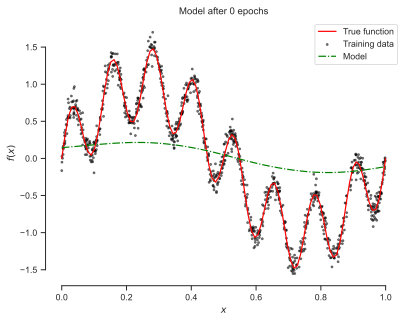

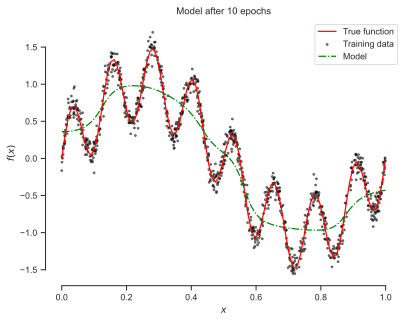

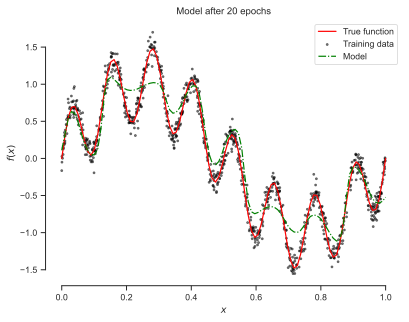

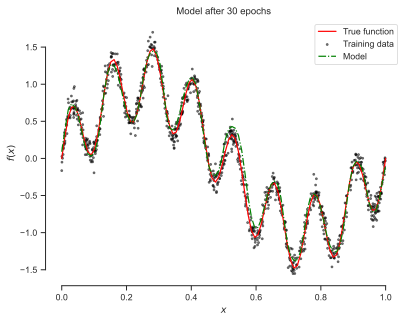

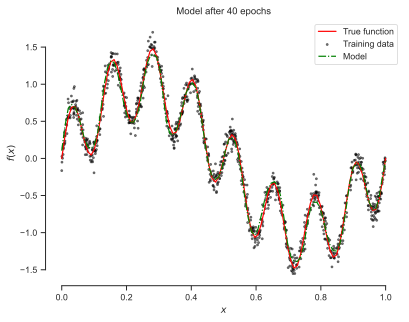

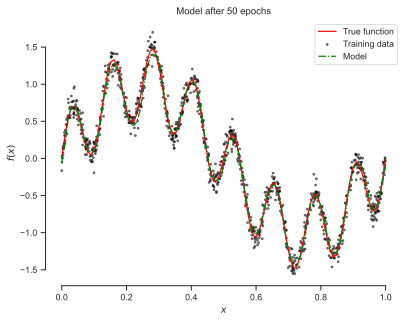

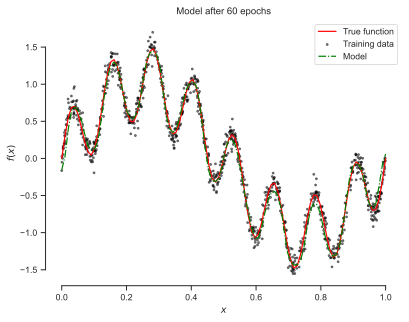

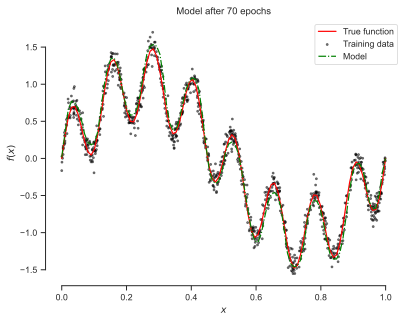

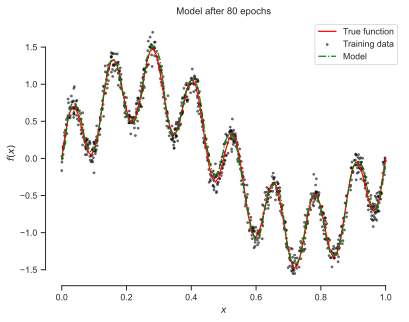

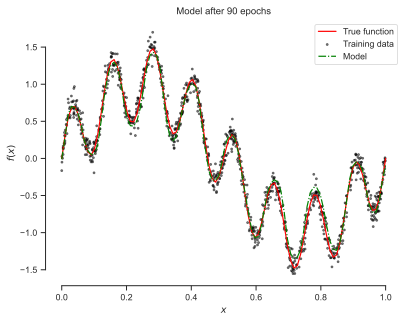

In [11]:
for e, model in enumerate(fourier_path[::10]):
    fig, ax = plot(model, x_train, y_train, f, style='g-.')
    ax.set_title(f"Model after {e * 10} epochs")

Notice that we learn the high-frequency component much faster than before.
Let's compare the two models side by side.

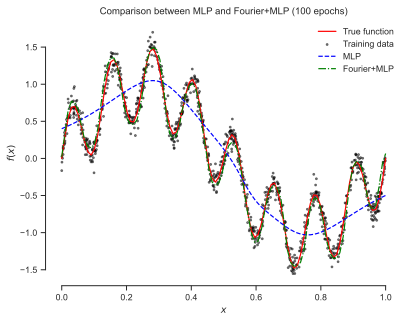

In [12]:
fig, ax = plt.subplots()
x = jnp.linspace(0, 1, 100)[:, None]
ax.plot(x, f(x), 'r-', label='True function')
ax.scatter(x_train, y_train, s=4, c='black', alpha=0.5, label='Training data')
ax.plot(x, path[99](x), 'b--', label='MLP')
ax.plot(x, fourier_path[99](x), 'g-.', label='Fourier+MLP')
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$f(x)$")
ax.set_title(r"Comparison between MLP and Fourier+MLP (100 epochs)")
plt.legend(loc='best', frameon=False);
sns.despine(trim=True);

## PINNs with Random Fourier Features

Let's now see if we can do any better with PINNs on our steady-state heat equation example.

In [93]:
def train_pinn(
        loss,
        fourier_mlp,
        key,
        optimizer,
        Lx=1.0,
        Ly=1.0,
        num_collocation_residual=512,
        num_iter=10_000,
        freq=1,
    ):

    # this is new
    filter_spec = fourier_mlp.make_filter_spec()

    # this is new
    def new_loss(diff_model, static_model, x, y):
        comb_model = eqx.combine(diff_model, static_model)
        return loss(comb_model, x, y)

    @eqx.filter_jit
    def step(opt_state, model, xs, ys):
        # added this line
        diff_model, static_model = eqx.partition(model, filter_spec)
        # changed the loss to the new loss
        value, grads = eqx.filter_value_and_grad(new_loss)(diff_model, static_model, xs, ys)
        updates, opt_state = optimizer.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, value
    
    opt_state = optimizer.init(eqx.filter(fourier_mlp, eqx.is_inexact_array))
    
    losses = []
    for i in range(num_iter):
        key1, key2, key = jrandom.split(key, 3)
        xb = jrandom.uniform(key1, (num_collocation_residual,), maxval=Lx)
        yb = jrandom.uniform(key2, (num_collocation_residual,), maxval=Ly)
        fourier_mlp, opt_state, value = step(opt_state, fourier_mlp, xb, yb)
        if i % freq == 0:
            losses.append(value)
            print(f"Step {i}, residual loss {value:.3e}")
    return fourier_mlp, losses

Let's build everything to train the model.
Notice that we need to rescale.

In [128]:
from jax import grad, vmap

u0 = 500 # degrees Kelvin
k = 10.0 # thermal conductivity in W/mK
Lx = 0.1 # meters
Ly = 1.0 # meters

to_x = lambda xt: xt * Lx
to_y = lambda yt: yt * Ly
to_xt = lambda x: x / Lx
to_yt = lambda y: y / Ly

source_term = lambda x, y: 2.0 * jnp.pi ** 2 * k * u0 * (
    -Lx ** 2 * jnp.sin(jnp.pi * x / Lx) ** 2 * jnp.cos(2.0 * jnp.pi * y / Ly)
    -Ly ** 2 * jnp.sin(jnp.pi * y / Ly) ** 2 * jnp.cos(2.0 * jnp.pi * x / Lx)
) / (Lx ** 2 * Ly ** 2)

key, subkey = jax.random.split(key)
num_fourier_features = 100
width_size = 128
depth = 4
fourier_mlp = FourierMLP(2, num_fourier_features, width_size, depth, subkey, sigma=6.0)

u_hat = lambda x, y, model: x * (1.0 - x) * y * (1.0 - y) * model.eval(jnp.array([x, y]))
u_x = grad(u_hat, 0)
u_y = grad(u_hat, 1)
u_xx = grad(u_x, 0)
u_yy = grad(u_y, 1)

# We need to find new scaling factors because the network structure has changed
v_u_xx = eqx.filter_jit(vmap(u_xx, in_axes=(0, 0, None)))
v_u_yy = eqx.filter_jit(vmap(u_yy, in_axes=(0, 0, None)))
max_u_xx = jnp.abs(v_u_xx(Xt.flatten(), Yt.flatten(), fourier_mlp)).max()
max_u_yy = jnp.abs(v_u_yy(Xt.flatten(), Yt.flatten(), fourier_mlp)).max()

# Calculate the scale:
fs = 9.96e+06
us = fs / k / max(max_u_xx, max_u_yy) / max(1/Lx**2, 1/Ly**2)
tkx = (k * us) / (Lx ** 2 * fs)
tky = (k * us) / (Ly ** 2 * fs)

print(f"Scale factor fs: {fs:.2e}")
print(f"Scale factor us: {us:.2e}")
print(f"tkx = {tkx:.3e}, tky = {tky:.3e}") 

tilde_source_term = lambda tx, ty: source_term(to_x(tx), to_y(ty)) / fs

pde_residual = vmap(
    lambda x, y, model: tkx * u_xx(x, y, model) + tky * u_yy(x, y, model) + tilde_source_term(x, y),
    in_axes=(0, 0, None))
pinn_loss = lambda model, x, y: jnp.mean(jnp.square(pde_residual(x, y, model)))

Scale factor fs: 9.96e+06
Scale factor us: 3.71e+04
tkx = 3.730e+00, tky = 3.730e-02


This is how we train:

In [139]:
key, subkey = jax.random.split(key)
optimizer = optax.adam(1e-3)
trained_fourier_mlp, losses = train_pinn(
    pinn_loss, fourier_mlp, key, optimizer, 
    num_collocation_residual=256, num_iter=2_000, freq=100, Lx=1.0, Ly=1.0)

Step 0, residual loss 2.723e-01
Step 100, residual loss 7.970e-05
Step 200, residual loss 3.138e-05
Step 300, residual loss 1.713e-05
Step 400, residual loss 1.211e-05
Step 500, residual loss 6.278e-06
Step 600, residual loss 6.382e-06
Step 700, residual loss 6.192e-06
Step 800, residual loss 4.549e-06
Step 900, residual loss 4.496e-06
Step 1000, residual loss 7.948e-06
Step 1100, residual loss 6.768e-06
Step 1200, residual loss 9.924e-06
Step 1300, residual loss 1.467e-05
Step 1400, residual loss 5.563e-06
Step 1500, residual loss 2.037e-05
Step 1600, residual loss 1.461e-05
Step 1700, residual loss 6.827e-06
Step 1800, residual loss 1.468e-05
Step 1900, residual loss 3.717e-05


Let's compare to the case of simple MLP:

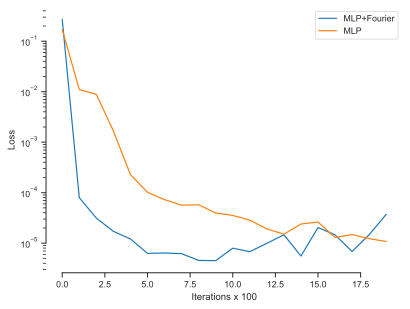

In [151]:
# Download the file if you are on Google Colab by uncommenting the next line
# curl -L -O https://github.com/PredictiveScienceLab/advanced-scientific-machine-learning/raw/main/book/pinns/mlp_losses.npz

import numpy as np
mlp_losses = np.load("mlp_losses.npz")["losses"]
fig, ax = plt.subplots()
ax.plot(losses, label="MLP+Fourier")
ax.plot(mlp_loss, label="MLP")
# set log scale for y axis
ax.set_yscale('log')
ax.set_xlabel("Iterations x 100")
ax.set_ylabel("Loss")
plt.legend(loc="best")
sns.despine(trim=True);

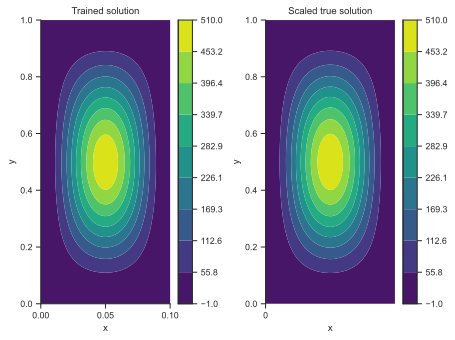

In [148]:
x = jnp.linspace(0, Lx, 100)
y = jnp.linspace(0, Ly, 100)
X, Y = jnp.meshgrid(x, y)
u_true = u0 * jnp.sin(jnp.pi * X / Lx) ** 2 * jnp.sin(jnp.pi * Y / Ly) ** 2

v_u_hat = vmap(u_hat, in_axes=(0, 0, None))
fig, ax = plt.subplots(1,2)
u_pred = v_u_hat(Xt.flatten(), Yt.flatten(), trained_fourier_mlp).reshape(X.shape)
c = ax[0].contourf(X, Y, u_pred * us, cmap='viridis',
    levels=jnp.linspace(-1, 510.0, 10))
fig.colorbar(c, ax=ax[0])
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title('Trained solution')
sns.despine(trim=True);
vsource_term = vmap(source_term, in_axes=(0, 0))
f = vsource_term(X.flatten(), Y.flatten()).reshape(X.shape)
c = ax[1].contourf(X, Y, u_true, cmap='viridis',
    levels=jnp.linspace(-1, 510.0, 10))
fig.colorbar(c, ax=ax[1])
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_title('Scaled true solution')
sns.despine(trim=True)
plt.tight_layout();

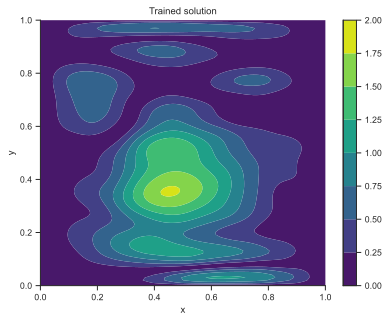

In [138]:
fig, ax = plt.subplots()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Trained solution')
c = ax.contourf(to_xt(X), to_yt(Y), jnp.abs(u_pred * us - u_true), cmap='viridis')
plt.colorbar(c, ax=ax)
sns.despine(trim=True);